In [6]:
e_coli_file = "./archivosParaDotplot/E_coli.fna"
salmonella_file = "./archivosParaDotplot/Salmonella.fna"

In [7]:
from Bio import SeqIO
import numpy as np


def merge_sequences_from_fasta(file_path):
    sequences = []
    for record in SeqIO.parse(file_path, "fasta"):
        sequences = np.append(sequences, record.seq)
    return "".join(sequences)

In [8]:
def sequence_str_to_uint8(sequence):
    return np.frombuffer(sequence.encode(), dtype=np.uint8)

In [9]:
e_coli_sequence = sequence_str_to_uint8(merge_sequences_from_fasta(e_coli_file))
salmonella_sequence = sequence_str_to_uint8(merge_sequences_from_fasta(salmonella_file))

In [15]:
print(len(e_coli_sequence))
print(len(salmonella_sequence))

print(len(e_coli_sequence) * len(salmonella_sequence))
print(len(e_coli_sequence) * len(salmonella_sequence) / 100)
print(
    (len(e_coli_sequence) * len(salmonella_sequence) / 100)
    / (len(e_coli_sequence) * len(salmonella_sequence))
)

4641652
4951383
22982596804716
229825968047.16
0.01


In [6]:
def dotplot_sequential(sequence1, sequence2, step_size=1):
    n_rows = len(sequence1) // step_size
    n_cols = len(sequence2) // step_size

    dotplot = np.zeros((n_rows, n_cols), dtype=bool)

    for i in range(n_rows):
        for j in range(n_cols):
            dotplot[i, j] = sequence1[i * step_size] == sequence2[j * step_size]

    return dotplot

In [7]:
import matplotlib.pyplot as plt


def plot_dotplot(dotplot):
    plt.figure(figsize=(10, 10))
    plt.imshow(dotplot, cmap="Greys", aspect="auto")
    plt.savefig("Resultado.png")

In [8]:
dotplot_result = dotplot_sequential(e_coli_sequence, salmonella_sequence, step_size=100)

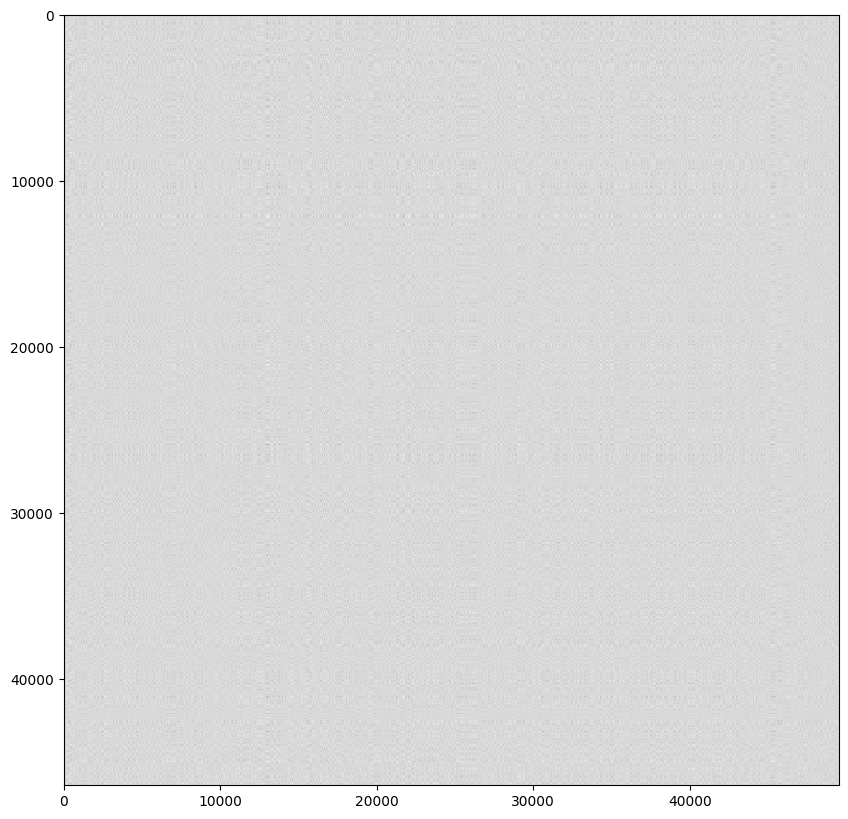

In [9]:
plot_dotplot(dotplot_result)

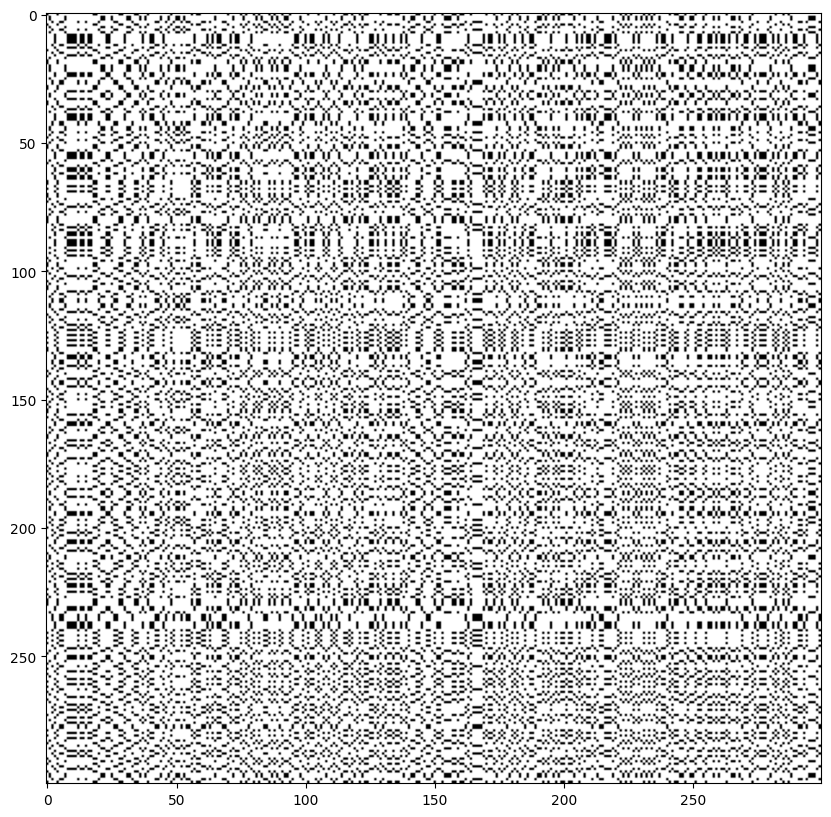

In [10]:
plot_dotplot(dotplot_result[:300, :300])

In [11]:
import multiprocessing as mp


def dotplot_multiprocessing_worker(args):
    start, end, sequence1, sequence2, step_size, dotplot = args
    for i in range(start, end):
        for j in range(dotplot.shape[1]):
            dotplot[i, j] = sequence1[i * step_size] == sequence2[j * step_size]
    return dotplot[start:end, :]


def dotplot_multiprocessing(processes_amount, sequence1, sequence2, step_size=1):
    n_rows = len(sequence1) // step_size
    n_cols = len(sequence2) // step_size

    dotplot = np.zeros((n_rows, n_cols), dtype=bool)

    # Dividir la matriz en bandas basado en el número de CPUs disponibles
    num_cpus = processes_amount
    rows_per_cpu = n_rows // num_cpus

    args = []
    for i in range(num_cpus):
        start = i * rows_per_cpu
        # El último proceso se ocupa de cualquier fila adicional
        end = (i + 1) * rows_per_cpu if i != num_cpus - 1 else n_rows
        args.append((start, end, sequence1, sequence2, step_size, dotplot))

    # Cada proceso se ocupa de una banda de la matriz
    with mp.Pool(num_cpus) as pool:
        results = pool.map(dotplot_multiprocessing_worker, args)

    # Combina las bandas procesadas en una matriz
    for i in range(num_cpus):
        start = i * rows_per_cpu
        end = (i + 1) * rows_per_cpu if i != num_cpus - 1 else n_rows
        dotplot[start:end, :] = results[i]

    return dotplot

In [12]:
dotplot_results_multiprocessing = dotplot_multiprocessing(
    5, e_coli_sequence, salmonella_sequence, step_size=100
)

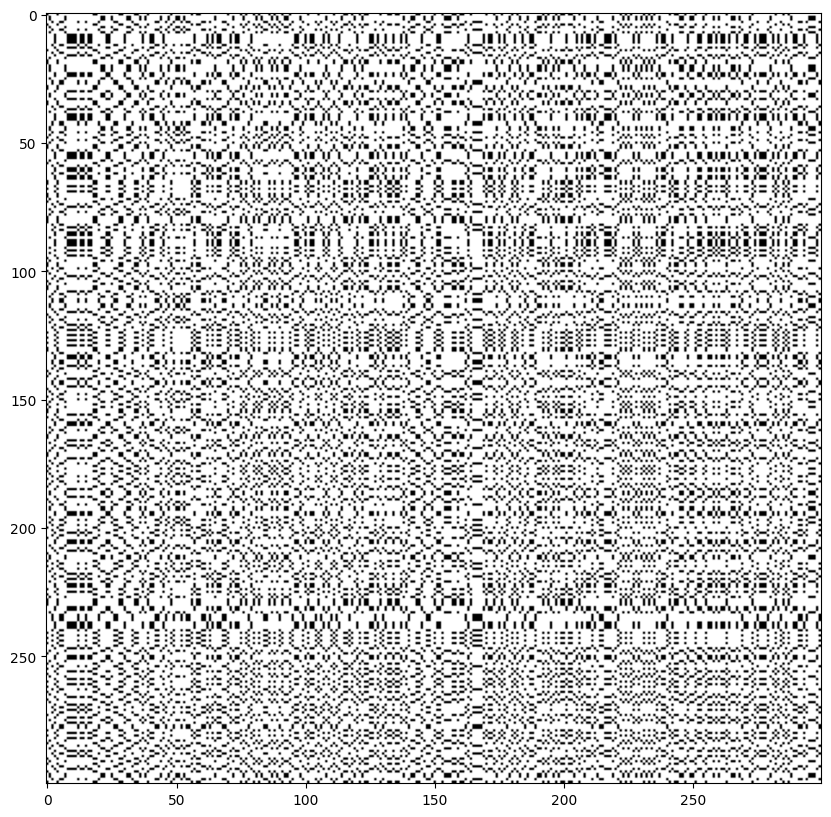

In [13]:
plot_dotplot(dotplot_results_multiprocessing[:300, :300])

In [104]:
def find_diagonals(grid, min_length):
    rows, cols = len(grid), len(grid[0])
    diagonals = []

    # top-left to bottom-right
    for x in range(rows):
        for y in range(cols):
            end_x, end_y = x, y
            while end_x < rows and end_y < cols and grid[end_x][end_y]:
                end_x += 1
                end_y += 1
            if end_x - x >= min_length and end_y - y >= min_length:
                diagonals.append(((x, y), (end_x - 1, end_y - 1)))

    # top-right to bottom-left
    for x in range(rows):
        for y in range(cols - 1, -1, -1):
            end_x, end_y = x, y
            while end_x < rows and end_y >= 0 and grid[end_x][end_y]:
                end_x += 1
                end_y -= 1
            if end_x - x >= min_length and y - end_y >= min_length:
                diagonals.append(((x, y), (end_x - 1, end_y + 1)))

    return diagonals

In [106]:
dotplot_diags = find_diagonals(dotplot_results_multiprocessing[:100, :100], 3)

In [50]:
def plot_dotplot_diagonals(dotplot, diagonals):
    plt.figure(figsize=(10, 10))
    plt.imshow(
        dotplot, cmap="Greys", aspect="auto"
    )  # Greys colorscheme gives a good contrast for dotplot
    for diagonal in diagonals:
        x, y = zip(*diagonal)  # unzip the (i, j) pairs into two lists
        plt.plot(
            y, x, color="red"
        )  # note that x and y are reversed because of the way plt.imshow works
    plt.show()

TypeError: 'numpy.bool_' object is not iterable

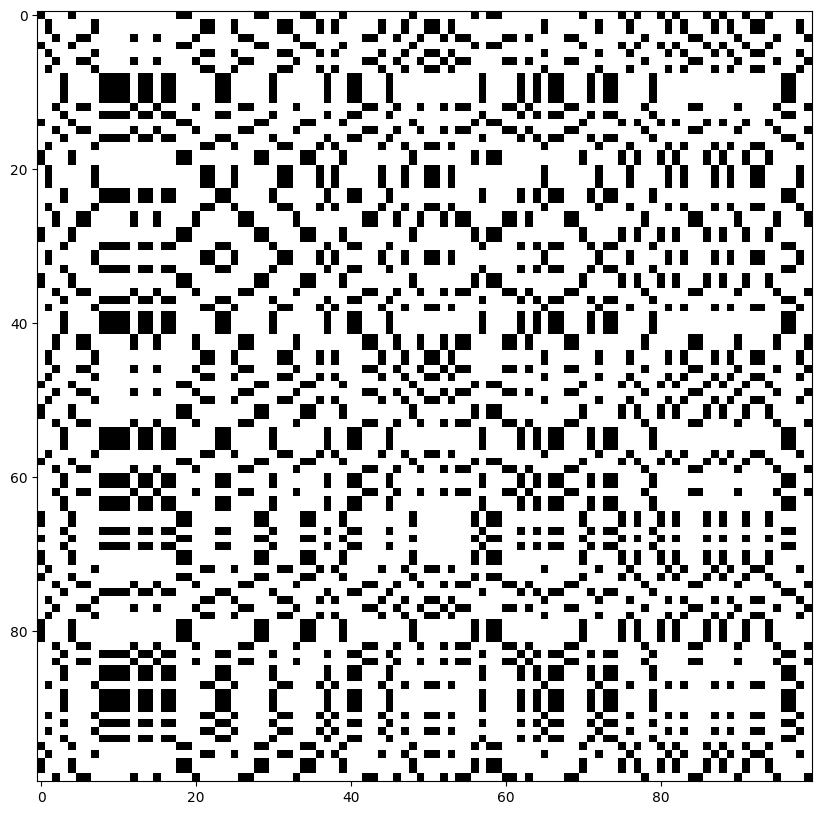

In [108]:
plot_dotplot_diagonals(
    dotplot_results_multiprocessing[:100, :100], dotplot_forward_diags
)

dotplot_diags[:10]

In [ ]:
# plot_dotplot_diagonals(
#     dotplot_results_multiprocessing[:300, :300], dotplot_diagonal_lines
# )

dotplot_diagonal_lines[:10]